In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('all.csv', index_col = 0)

## Format data for model

In [3]:
df['fuel_other'] = df['fuel_flexfuel'] | df['fuel_elec_or_hybrid']

In [4]:
df = df.drop(['fuel_flexfuel','fuel_elec_or_hybrid', 'fuel_electric', 'fuel_hybrid'], axis = 1)

In [5]:
expanded_other = (df['make_chevrolet'] |
                  df['make_dodge'] |
                  df['make_gmc'] |
                  df['make_lincoln'] |
                  df['make_mercury'] |
                  df['make_mitsubishi_fuso'] |
                  df['make_nissan'] |
                  df['make_other'] |
                  df['make_toyota']
                 )

In [6]:
df['make_other'] = expanded_other

In [7]:
df = df.drop(['make_chevrolet',
                'make_dodge',
                'make_gmc',
                'make_lincoln',
                'make_mercury',
                'make_mitsubishi_fuso',
                'make_nissan',
                'make_toyota'], axis = 1)

## Create x and y dataframes

In [8]:
df_y = df[[col for col in df.columns if 'y_' in col]]

In [9]:
df_x = df.drop([col for col in df.columns if 'y_' in col], axis = 1)

In [10]:
df_x = df_x.drop(['make', 'op_descriptions', 'date', 'fuel', 'appointment_month', 'season', 'year', 'error_code'], axis = 1)

In [28]:
plot_heatmap = False

if plot_heatmap == True:
    corr = df_y.corr()
    corr.columns = [i[2:].replace('_', ' ') for i in corr.columns]
    corr.index = [i[2:].replace('_', ' ') for i in corr.index]
    fig, ax = plt.subplots(figsize=(12,9))
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    plt.show()

In [50]:
plot_features_per_string = False

if plot_features_per_string == True:
    features_per_string = df_y.sum(axis = 1).value_counts() / df_y.shape[0]
    fig, ax = plt.subplots(figsize=(9,6))
    sns.barplot(x = features_per_string.index, y = features_per_string, palette = 'hls')
    sns.despine()
    plt.show()

In [34]:
df_y.sum(axis = 1).value_counts()

1    9300
2    3320
3    1536
4    1289
5     447
6     277
7      24
dtype: int64

In [12]:
df['y_multi_point_inspection'].value_counts()

0    10462
1     5731
Name: y_multi_point_inspection, dtype: int64

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score

## Random Forest

In [14]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')

In [15]:
y = df['y_multi_point_inspection']
x = df_x.fillna(df_x.median())

In [16]:
clf.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

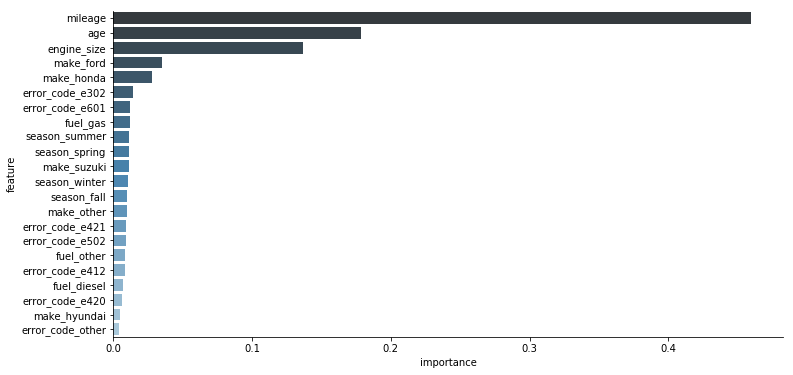

In [67]:
features = pd.DataFrame()
features['feature'] = x.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(y = features.index,
            x = features['importance'],
            palette = 'Blues_d',
            orient = 'h')
sns.despine()
plt.show()

In [91]:
model_dict = {}

for output_col in df_y.columns:
    
    print('Fitting ', output_col)
    y = df_y[output_col]
    
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(y, n_folds=5)

    grid_search = GridSearchCV(forest,
                               scoring='f1',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose = 1)

    grid_search.fit(x, y)
    model_dict[output_col] = grid_search

Fitting  y_bespoke
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  4.8min finished


Fitting  y_multi_point_inspection
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.3min finished


Fitting  y_battery_test
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.3min finished


Fitting  y_tire_inflation
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.0min finished


Fitting  y_hazardous_waste
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.0min finished


Fitting  y_change_oil
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  4.9min finished


Fitting  y_filter
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  4.8min finished


Fitting  y_belts_and_hoses
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.0min finished


Fitting  y_air_filter
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.3min finished


Fitting  y_safety_systems
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.1min finished


Fitting  y_nitro_fill
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.3min finished


Fitting  y_repair_or_refinish
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  5.5min finished


In [98]:
df_x.loc[1,:]

make_ford               1.0
make_honda              0.0
make_hyundai            0.0
make_other              0.0
make_suzuki             0.0
engine_size             3.0
mileage             73283.0
fuel_diesel             0.0
fuel_gas                1.0
season_fall             0.0
season_spring           0.0
season_summer           0.0
season_winter           1.0
age                     4.0
error_code_e302         0.0
error_code_e412         0.0
error_code_e420         0.0
error_code_e421         0.0
error_code_e502         0.0
error_code_e601         1.0
error_code_other        0.0
fuel_other              0.0
Name: 1, dtype: float64

In [104]:
model_dict['y_battery_test'].predict_proba(example)[0][1]

AttributeError: 'GridSearchCV' object has no attribute 'classes_'

In [117]:
example = df_x.loc[100,:]
example_probs = pd.DataFrame()

for output_col in df_y.columns:
    
    example_probs.loc['prob', output_col] = model_dict[output_col].predict_proba(example)[0][1]

In [118]:
example_probs

,y_bespoke,y_multi_point_inspection,y_battery_test,y_tire_inflation,y_hazardous_waste,y_change_oil,y_filter,y_belts_and_hoses,y_air_filter,y_safety_systems,y_nitro_fill,y_repair_or_refinish
prob,0.523643,0.256633,0.101279,0.008721,0.005537,0.045832,0.121483,0.01596,0.017068,0.017879,0.380692,0.046155


In [119]:
example_probs.T.squeeze().sort_values(ascending = False)

y_bespoke                   0.523643
y_nitro_fill                0.380692
y_multi_point_inspection    0.256633
y_filter                    0.121483
y_battery_test              0.101279
y_repair_or_refinish        0.046155
y_change_oil                0.045832
y_safety_systems            0.017879
y_air_filter                0.017068
y_belts_and_hoses           0.015960
y_tire_inflation            0.008721
y_hazardous_waste           0.005537
Name: prob, dtype: float64

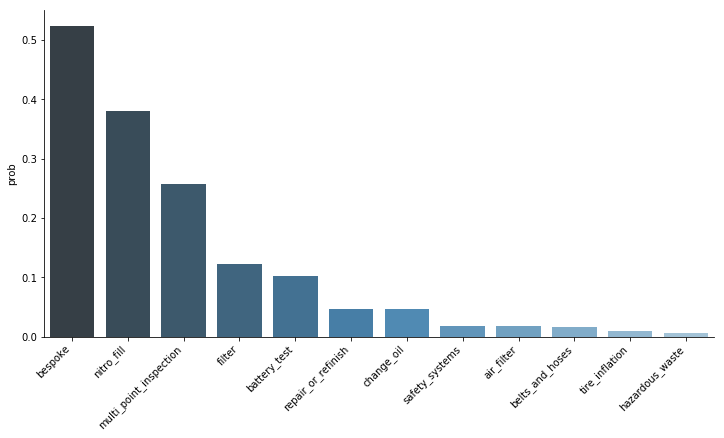

In [121]:
fig, ax = plt.subplots(figsize=(12,6))
to_plot = example_probs.T.squeeze().sort_values(ascending = False)
sns.barplot(x = [col[2:] for col in to_plot.index], y = to_plot, palette = 'Blues_d')
sns.despine()
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [125]:
sk.metrics.f1_score(y, y_pred)

0.042004773269689731

In [124]:
y.sum()

2047

In [114]:
results = pd.DataFrame()

for output_col in df_y.columns:
    
    y_pred = model_dict[output_col].predict(x)
    
    results.loc[output_col, 'accuracy'] = sk.metrics.accuracy_score(y, y_pred)
    results.loc[output_col, 'precision'] = sk.metrics.precision_score(y, y_pred)
    results.loc[output_col, 'recall'] = sk.metrics.recall_score(y, y_pred)
    results.loc[output_col, 'f-score'] = sk.metrics.f1_score(y, y_pred)
    results.loc[output_col, 'roc auc'] = sk.metrics.roc_auc_score(y, y_pred)

In [115]:
results

,accuracy,precision,recall,f-score,roc auc
y_bespoke,0.713086,0.045152,0.063019,0.052610,0.435087
y_multi_point_inspection,0.604582,0.135176,0.394235,0.201322,0.514628
y_battery_test,0.867288,0.081967,0.004885,0.009221,0.498484
y_tire_inflation,0.754832,0.124561,0.155838,0.138455,0.498674
y_hazardous_waste,0.857346,0.087774,0.013679,0.023669,0.496554
y_change_oil,0.873587,0.000000,0.000000,0.000000,0.500000
y_filter,0.870067,0.047619,0.001466,0.002844,0.498612
y_belts_and_hoses,0.873587,0.000000,0.000000,0.000000,0.500000
y_air_filter,0.873587,0.000000,0.000000,0.000000,0.500000
y_safety_systems,0.873526,0.000000,0.000000,0.000000,0.499965


In [ ]:
joblib.dump(model, 'multi_point_inspection.pkl')

In [20]:
from sklearn.externals import joblib

In [21]:
joblib.dump(clf, 'multi_point_inspection.pkl')

['multi_point_inspection.pkl']

In [72]:
y = df_y['y_battery_test']

In [127]:
for output_col in df_y.columns:
    joblib.dump(model_dict[output_col], 'rf_' + output_col + '.pkl')

In [132]:
from sklearn.preprocessing import StandardScaler

In [137]:
scaler = StandardScaler()

## k-Nearest Neighbors

In [144]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
x[['engine_size', 'mileage', 'age']] = scaler.fit_transform(df_x[['engine_size', 'mileage', 'age']].fillna(df_x.median()))

In [145]:
knn_model_dict = {}

for output_col in df_y.columns:
    
    print('Fitting', output_col)
    y = df_y[output_col]
    
    parameter_grid = {
                 'n_neighbors' : [1,3,10,20],
                 'leaf_size': [10, 30, 100]
                 }
    knn = KNeighborsClassifier()
    cross_validation = StratifiedKFold(y, n_folds=5)

    grid_search = GridSearchCV(knn,
                               scoring='f1',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose = 1)

    grid_search.fit(x, y)
    knn_model_dict[output_col] = grid_search

Fitting  y_bespoke
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   23.2s finished


Fitting  y_multi_point_inspection
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   24.5s finished


Fitting  y_battery_test
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   26.9s finished


Fitting  y_tire_inflation
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   29.6s finished


Fitting  y_hazardous_waste
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   26.9s finished


Fitting  y_change_oil
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   28.7s finished


Fitting  y_filter
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   24.7s finished


Fitting  y_belts_and_hoses
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   26.2s finished


Fitting  y_air_filter
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   30.9s finished


Fitting  y_safety_systems
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   27.5s finished


Fitting  y_nitro_fill
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   32.3s finished


Fitting  y_repair_or_refinish
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   30.8s finished


In [212]:
knn_model_dict['y_repair_or_refinish'].best_params_

{'leaf_size': 30, 'n_neighbors': 1}

In [146]:
knn_results = pd.DataFrame()

for output_col in df_y.columns:
    
    y_pred = knn_model_dict[output_col].predict(x)
    
    knn_results.loc[output_col, 'accuracy'] = sk.metrics.accuracy_score(y, y_pred)
    knn_results.loc[output_col, 'precision'] = sk.metrics.precision_score(y, y_pred)
    knn_results.loc[output_col, 'recall'] = sk.metrics.recall_score(y, y_pred)
    knn_results.loc[output_col, 'f-score'] = sk.metrics.f1_score(y, y_pred)

In [148]:
knn_results.index = [row[2:].replace('_', ' ') for row in knn_results.index]

In [151]:
knn_results = knn_results.drop('roc auc', axis = 1)

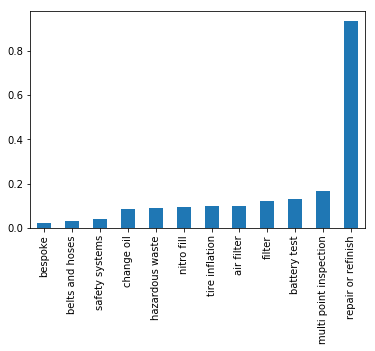

In [159]:
knn_results['f-score'].sort_values().plot(kind = 'bar')
plt.show()

In [160]:
knn_results

,accuracy,precision,recall,f-score
bespoke,0.567282,0.015625,0.039082,0.022325
multi point inspection,0.614525,0.116194,0.310210,0.169063
battery test,0.683505,0.101295,0.191011,0.132385
tire inflation,0.781943,0.102784,0.093796,0.098084
hazardous waste,0.818008,0.123746,0.072301,0.091274
change oil,0.800716,0.103495,0.075232,0.087129
filter,0.671216,0.091295,0.178798,0.120872
belts and hoses,0.812759,0.046083,0.024426,0.031928
air filter,0.824060,0.141964,0.077675,0.100410
safety systems,0.796023,0.048851,0.033219,0.039546


## SVM

In [161]:
from sklearn.svm import LinearSVC

In [164]:
svm_model_dict = {}

for output_col in df_y.columns:
    
    print('Fitting', output_col)
    y = df_y[output_col]
    
    parameter_grid = {
                 'loss': ['hinge', 'squared_hinge']
                 }
    svm = LinearSVC()
    cross_validation = StratifiedKFold(y, n_folds=5)

    grid_search = GridSearchCV(svm,
                               scoring='f1',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose = 1)

    grid_search.fit(x, y)
    svm_model_dict[output_col] = grid_search

Fitting y_bespoke
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


Fitting y_multi_point_inspection
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


Fitting y_battery_test
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


Fitting y_tire_inflation
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished


Fitting y_hazardous_waste
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting y_change_oil
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished


Fitting y_filter
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.5s finished


Fitting y_belts_and_hoses
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


Fitting y_air_filter
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


Fitting y_safety_systems
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


Fitting y_nitro_fill
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


Fitting y_repair_or_refinish
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.3s finished


In [165]:
svm_results = pd.DataFrame()

for output_col in df_y.columns:
    
    y_pred = svm_model_dict[output_col].predict(x)
    
    svm_results.loc[output_col, 'accuracy'] = sk.metrics.accuracy_score(y, y_pred)
    svm_results.loc[output_col, 'precision'] = sk.metrics.precision_score(y, y_pred)
    svm_results.loc[output_col, 'recall'] = sk.metrics.recall_score(y, y_pred)
    svm_results.loc[output_col, 'f-score'] = sk.metrics.f1_score(y, y_pred)

In [166]:
svm_results.index = [row[2:].replace('_', ' ') for row in svm_results.index]

In [167]:
svm_results

,accuracy,precision,recall,f-score
bespoke,0.805224,0.045939,0.027357,0.034293
multi point inspection,0.684123,0.144907,0.305813,0.196639
battery test,0.871611,0.203704,0.005374,0.010471
tire inflation,0.742173,0.119728,0.163654,0.138287
hazardous waste,0.873649,1.000000,0.000489,0.000977
change oil,0.873587,0.000000,0.000000,0.000000
filter,0.873340,0.300000,0.001466,0.002917
belts and hoses,0.873587,0.000000,0.000000,0.000000
air filter,0.873587,0.000000,0.000000,0.000000
safety systems,0.873587,0.000000,0.000000,0.000000


## Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression

In [170]:
lr_model_dict = {}

for output_col in df_y.columns:
    
    print('Fitting', output_col)
    y = df_y[output_col]
    
    parameter_grid = {
                 'penalty': ['l1', 'l2']
                 }
    lr = LogisticRegression()
    cross_validation = StratifiedKFold(y, n_folds=5)

    grid_search = GridSearchCV(lr,
                               scoring='f1',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose = 1)

    grid_search.fit(x, y)
    lr_model_dict[output_col] = grid_search

Fitting y_bespoke
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting y_multi_point_inspection
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


Fitting y_battery_test
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


Fitting y_tire_inflation
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished


Fitting y_hazardous_waste
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


Fitting y_change_oil
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


Fitting y_filter
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting y_belts_and_hoses
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished


Fitting y_air_filter
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


Fitting y_safety_systems
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


Fitting y_nitro_fill
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


Fitting y_repair_or_refinish
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [171]:
lr_results = pd.DataFrame()

for output_col in df_y.columns:
    
    y_pred = lr_model_dict[output_col].predict(x)
    
    lr_results.loc[output_col, 'accuracy'] = sk.metrics.accuracy_score(y, y_pred)
    lr_results.loc[output_col, 'precision'] = sk.metrics.precision_score(y, y_pred)
    lr_results.loc[output_col, 'recall'] = sk.metrics.recall_score(y, y_pred)
    lr_results.loc[output_col, 'f-score'] = sk.metrics.f1_score(y, y_pred)

In [172]:
lr_results

,accuracy,precision,recall,f-score
y_bespoke,0.793862,0.056357,0.040059,0.046830
y_multi_point_inspection,0.682641,0.145413,0.309722,0.197909
y_battery_test,0.862595,0.138211,0.016610,0.029655
y_tire_inflation,0.762552,0.123534,0.144113,0.133033
y_hazardous_waste,0.867721,0.094017,0.005374,0.010166
y_change_oil,0.873649,1.000000,0.000489,0.000977
y_filter,0.873279,0.272727,0.001466,0.002915
y_belts_and_hoses,0.873587,0.000000,0.000000,0.000000
y_air_filter,0.873587,0.000000,0.000000,0.000000
y_safety_systems,0.873587,0.000000,0.000000,0.000000


## Principal Components Analysis

In [177]:
x_pca = scaler.fit_transform(x.fillna(df_x.median()))

In [175]:
from sklearn.decomposition import PCA

In [184]:
x_pca

array([[-0.98437452, -0.46619281, -0.28176127, ...,  1.83110813,
        -0.1550189 , -0.42283237],
       [ 1.01587351, -0.46619281, -0.28176127, ...,  1.83110813,
        -0.1550189 , -0.42283237],
       [ 1.01587351, -0.46619281, -0.28176127, ..., -0.54611739,
        -0.1550189 , -0.42283237],
       ..., 
       [-0.98437452,  2.14503521, -0.28176127, ..., -0.54611739,
        -0.1550189 , -0.42283237],
       [-0.98437452,  2.14503521, -0.28176127, ..., -0.54611739,
        -0.1550189 , -0.42283237],
       [-0.98437452,  2.14503521, -0.28176127, ..., -0.54611739,
        -0.1550189 , -0.42283237]])

In [182]:
y_pca = df_y['y_repair_or_refinish']

explained variance ratio (first two components): [ 0.12615329  0.10063317]


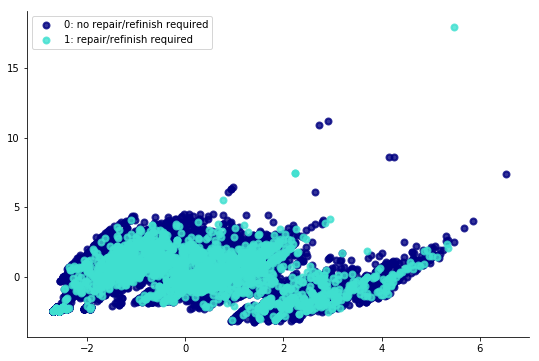

In [211]:
target_names = ['0: no repair/refinish required', '1: repair/refinish required']

pca = PCA(n_components=2)
X_r = pca.fit(x_pca).transform(x_pca)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize = (9,6))
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='upper left', shadow=False, scatterpoints=1)
sns.despine()
plt.show()